<a href="https://colab.research.google.com/github/zhantia1/mall-customer-clusters/blob/main/Unsupervised_Learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project I am attempting to create a unsupervised learning model for clustering customers for a mall. This is useful for the owner of malls to be able to target portions of the customerbase with certain ads or promotions to boost sales. This model is trained using customer data found on kaggle here: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data

In [ ]:
!pip install kaggle

First we import the dataset into this google colab. We will need a Kaggle API key which you can then place into your google drive for easy retrieval. The full instructions can be found here: https://saturncloud.io/blog/importing-datasets-from-kaggle-to-google-colab/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python

  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 3.39MB/s]


In [ ]:
import zipfile

file_path = 'customer-segmentation-tutorial-in-python.zip'

# # Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('customer-segmentation')  # Replace 'destination_folder' with your desired folder

The data analysis of the notebook starts here. We begin by doing some preliminary EDA. Examining the data with `df.head()` and `df.info()`.

In [ ]:
import pandas as pd

df = pd.read_csv('customer-segmentation/Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


This data set is pretty clean so not a lot of need for cleaning. We convert Gender to a binary categorical variable to be able to run `df.corr()`. We also get some summary statistics as well as draw some graphs to visualize the data.

       CustomerID      Gender         Age  Annual Income (k$)  \
count  200.000000  200.000000  200.000000          200.000000   
mean   100.500000    0.560000   38.850000           60.560000   
std     57.879185    0.497633   13.969007           26.264721   
min      1.000000    0.000000   18.000000           15.000000   
25%     50.750000    0.000000   28.750000           41.500000   
50%    100.500000    1.000000   36.000000           61.500000   
75%    150.250000    1.000000   49.000000           78.000000   
max    200.000000    1.000000   70.000000          137.000000   

       Spending Score (1-100)  
count              200.000000  
mean                50.200000  
std                 25.823522  
min                  1.000000  
25%                 34.750000  
50%                 50.000000  
75%                 73.000000  
max                 99.000000  


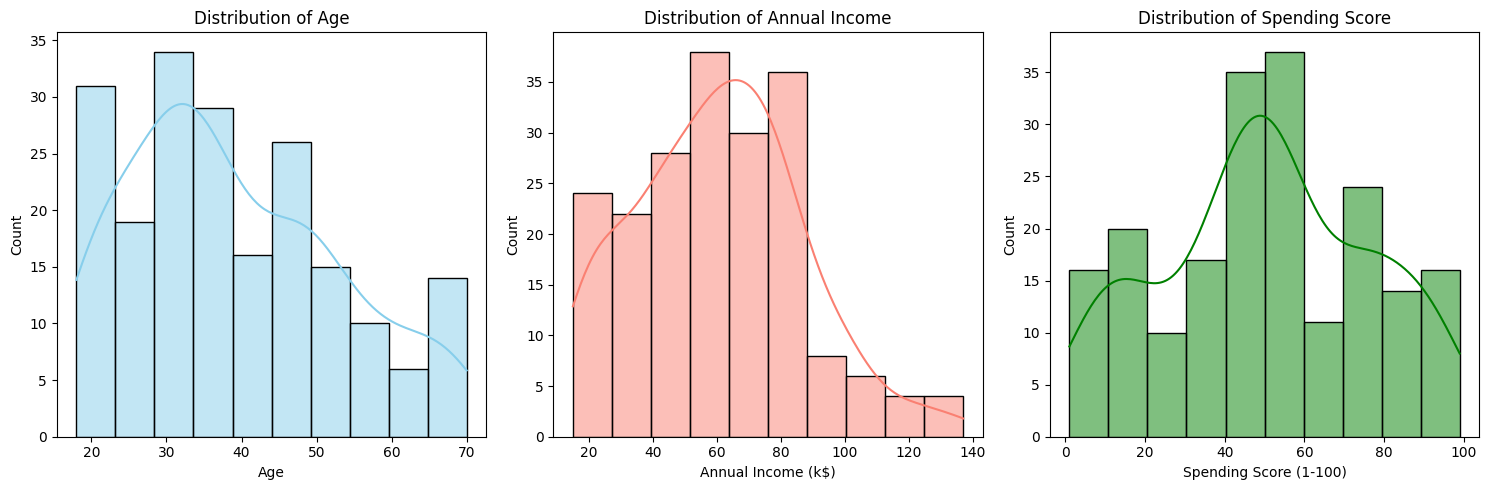

<ipython-input-65-6457bc9152f0>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='Set2')


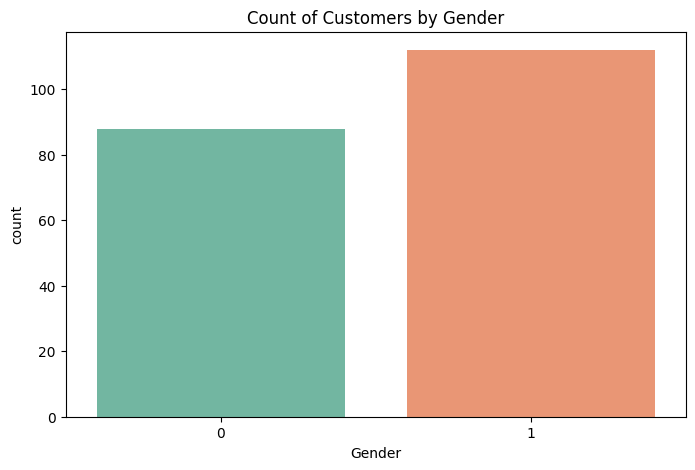

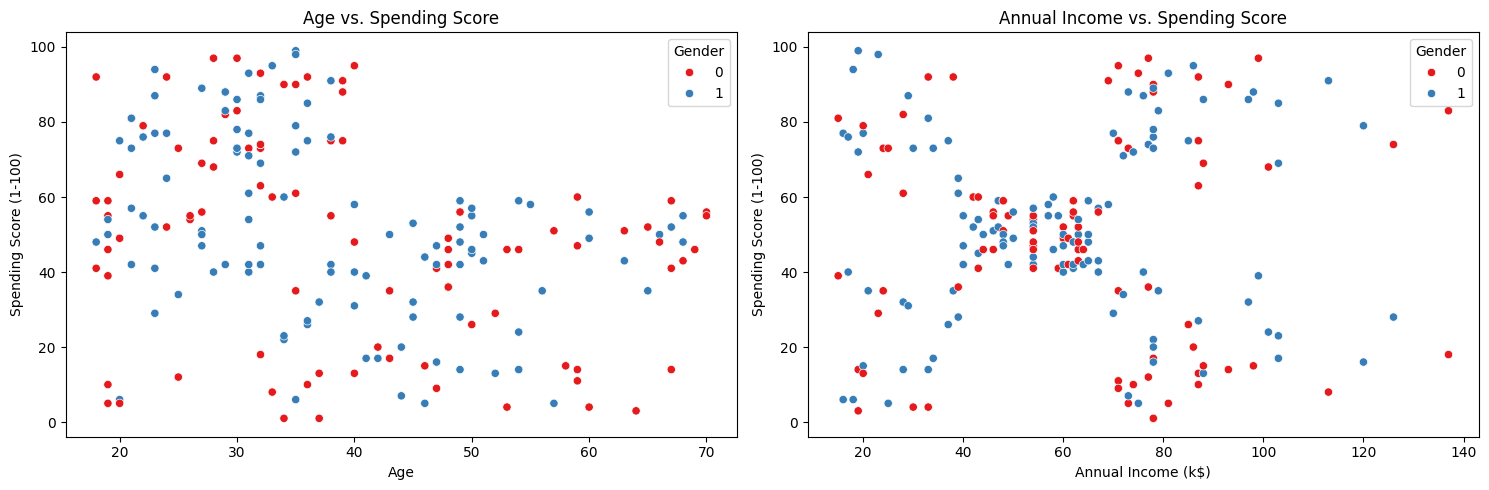

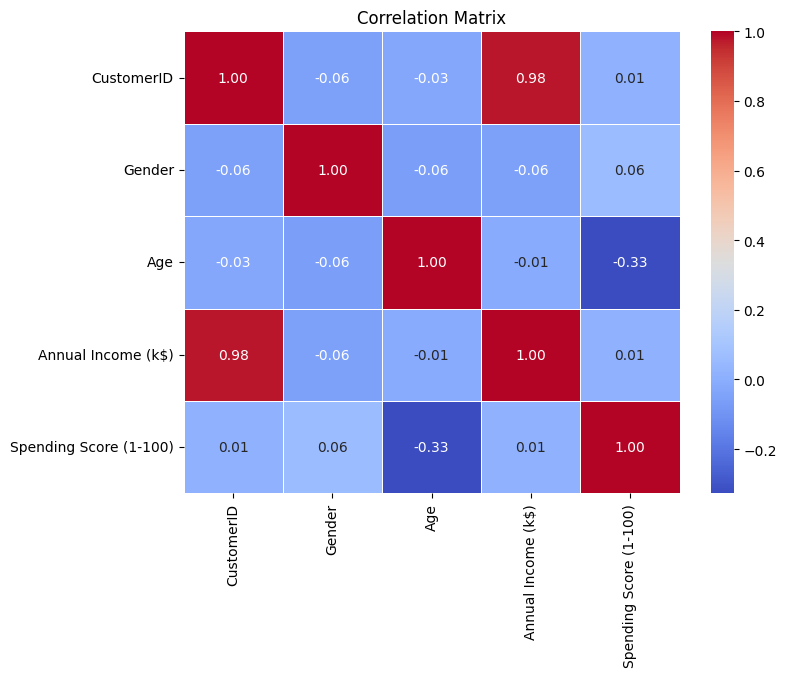

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.dropna()
# clean gender to numeric values for correlation
gender_map = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_map)

# Summary Statistics
summary_stats = df.describe()
print(summary_stats)

# Visualize Distribution of Numerical Variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['Age'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], bins=10, kde=True, color='salmon')
plt.title('Distribution of Annual Income')

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], bins=10, kde=True, color='green')
plt.title('Distribution of Spending Score')

plt.tight_layout()
plt.show()

# Visualize Categorical Variables
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=df, palette='Set2')
plt.title('Count of Customers by Gender')
plt.show()

# Explore Relationships
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, hue='Gender', palette='Set1')
plt.title('Age vs. Spending Score')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Gender', palette='Set1')
plt.title('Annual Income vs. Spending Score')

plt.tight_layout()
plt.show()

# Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

From the preliminary viewing of the graphs, it seems when plotting Spending Score (1-100) vs Age and Spending Score (1-100) vs Annual Income (k\$) is our best bet at creating meaningful clusters. We will focus on Spending Score (1-100) vs Annual Income (k\$) as our dimensions for creating clusters for the rest of this notebook.

I will perform both Agglomerative clustering and KMeans clustering for this dataset. We start with Agglomerative clustering. I begin by guessing a number of clusters based on visual inspection of the previous graph. It seems like there are 5 distinct clusters. Later I will find use a dendrogram to find the number of clusters.

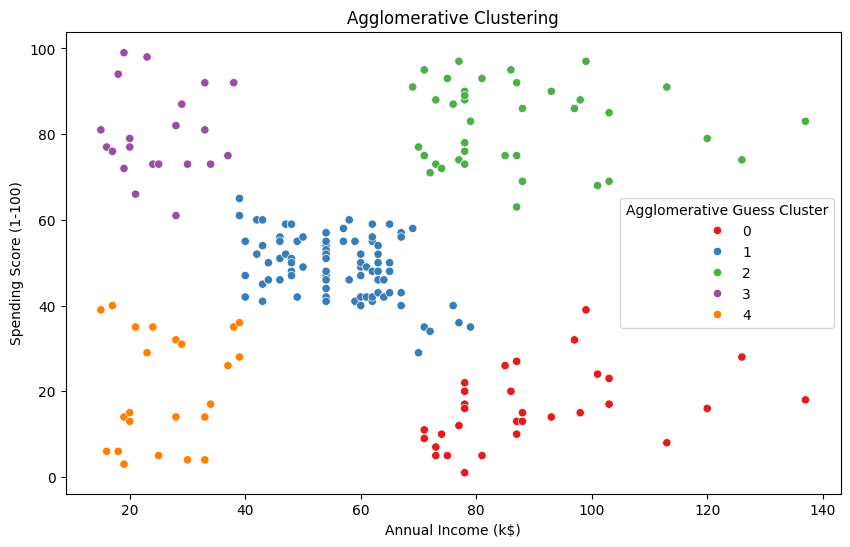

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import time

# guessing a number of clusters based on image
n_clusters = 5

# Extracting features for clustering
X = df[['Spending Score (1-100)','Annual Income (k$)']]

# Perform Agglomerative Clustering
start_agg_guess = time.time()
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = agg_cluster.fit_predict(X)
end_agg_guess = time.time()
elapsed_agg_guess = end_agg_guess - start_agg_guess

# # Add cluster labels to the DataFrame
df['Agglomerative Guess Cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Agglomerative Guess Cluster', palette='Set1')
plt.title('Agglomerative Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Print cluster centers (if available, depending on linkage method used)
if hasattr(agg_cluster, 'cluster_centers_'):
    print("Cluster Centers:")
    print(agg_cluster.cluster_centers_)

Visually it looks like it did a pretty good job of clustering the data. We will now use a dendrogram to visualize the distance between the data points.

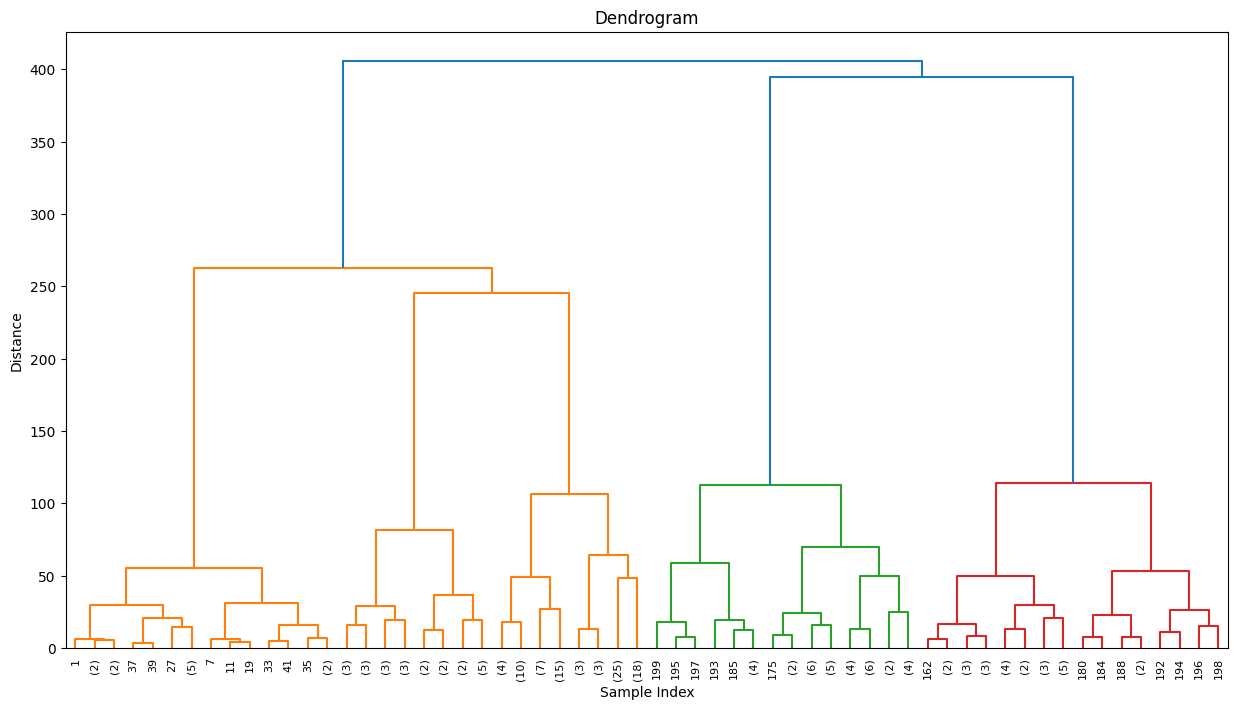

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform Agglomerative Clustering without specifying the number of clusters
start_agg = time.time()
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)  # Setting distance_threshold=0 for full dendrogram
cluster_labels = agg_cluster.fit_predict(X)

# Compute linkage matrix
linkage_matrix = linkage(X, method='ward')

end_agg = time.time()
elapsed_agg = end_agg - start_agg

# Visualize the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, p=5, truncate_mode='level', leaf_rotation=90., leaf_font_size=8.)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

The dendrogram shows the attribute distances between each pair of merged clusters. Since the furthest distance is 400, I decided to use a distance score of 200 to cut off the dendrogram to create our clusters.

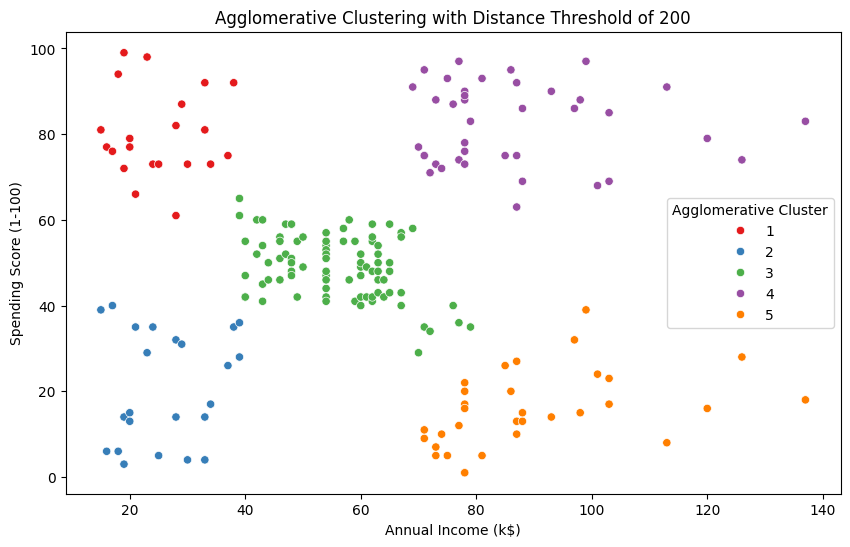

In [ ]:
from scipy.cluster.hierarchy import fcluster
distance_threshold = 200

# Determine cluster labels based on the distance threshold
cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')

# Add cluster labels to the DataFrame
df['Agglomerative Cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Agglomerative Cluster', palette='Set1')
plt.title('Agglomerative Clustering with Distance Threshold of 200')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

The results look pretty good. It just so happens that it also clustered the data into 5 different clusters like from our intial guess. Using both the model I guessed n_clusters, and the dendrogram model, I generated the predicted cluster for each of the customers in our dataset which can be seen below.

Note: The Cluster IDs between the models are not 1-1. If customer 0 is in cluster 4 in one model and cluster 2 in another model, that doesn't mean they don't appear in the same area on the graph of Spending Score vs Annual Income. If you view the 2 graphs above you'll notice that in the first graph being in cluster 3 means in the second graph the same data point will be in cluster 1 at the same position on the graph.

In [ ]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Agglomerative Guess Cluster,Agglomerative Cluster
0,1,0,19,15,39,4,2
1,2,0,21,15,81,3,1
2,3,1,20,16,6,4,2
3,4,1,23,16,77,3,1
4,5,1,31,17,40,4,2
5,6,1,22,17,76,3,1
6,7,1,35,18,6,4,2
7,8,1,23,18,94,3,1
8,9,0,64,19,3,4,2
9,10,1,30,19,72,3,1


Next we will use KMeans clustering to find the clusters. We begin by programtically increasing the k value and drawing an elbow plot to find the optimal number of clusters to use for our model.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

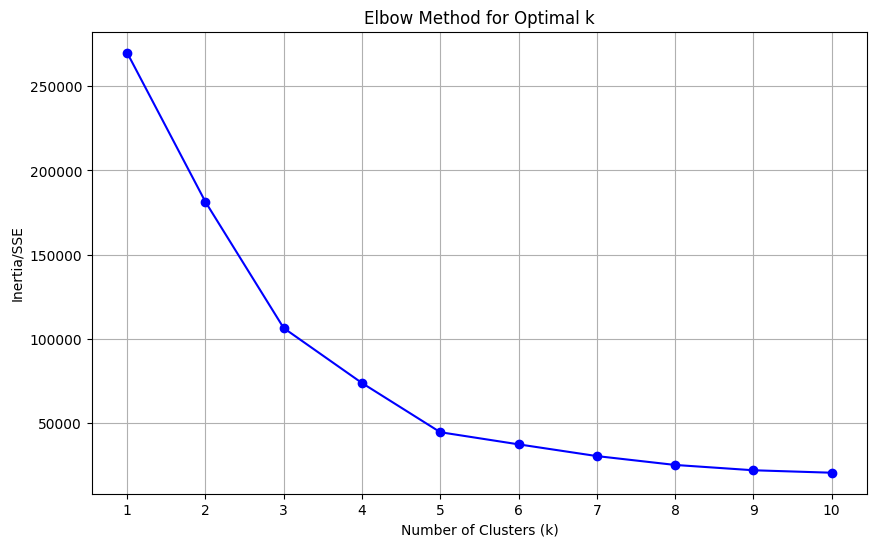

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Calculate inertia for different k values
inertia = []
start_k_elbow = time.time()
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

end_k_elbow = time.time()
elapsed_k_elbow = end_k_elbow - start_k_elbow

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia/SSE')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

From the elbow plot, we can conclude that the optimal number of clusters is 5 since that is when the rate of decrease in SSE drops off the most. We use this to train our KMeans model with 500 max iterations to let the centroid converge to its optimal spot for finding clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centroids:
[[79.36363636 25.72727273]
 [17.11428571 88.2       ]
 [49.51851852 55.2962963 ]
 [82.12820513 86.53846154]
 [20.91304348 26.30434783]]


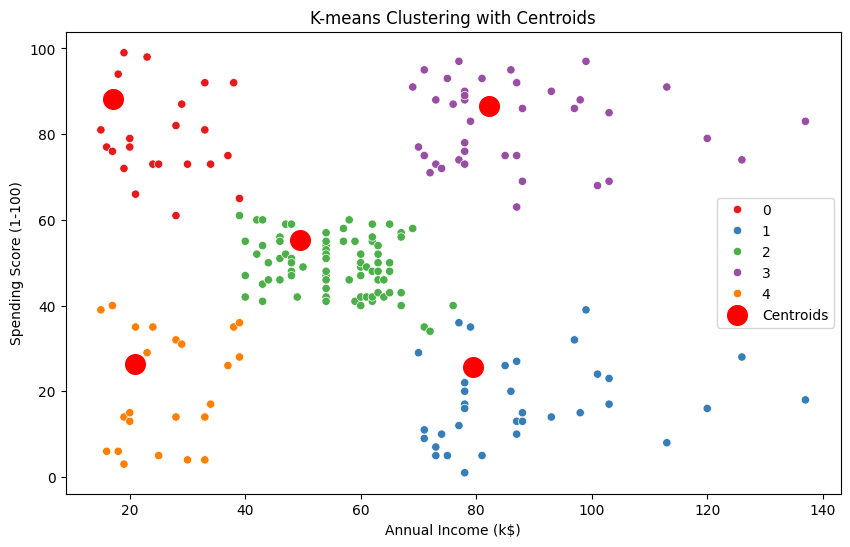

In [ ]:
# Judging by the elbow graph the optimal k is either 4 or 5. Let's use 5
optimal_k = 5

# Perform K-means clustering with optimal number of clusters
start_time_kmeans = time.time()
kmeans = KMeans(n_clusters=optimal_k, max_iter=500)
cluster_labels = kmeans.fit_predict(X)
end_time_kmeans = time.time()
elapsed_time_kmeans = end_time_kmeans - start_time_kmeans

# Add cluster labels to the DataFrame
df['KMeans Cluster'] = cluster_labels

# Get centroids of each cluster
centroids = kmeans.cluster_centers_

# Print centroids
print("Cluster Centroids:")
print(centroids)

# Visualize the clusters with centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='KMeans Cluster', palette='Set1')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, c='red', label='Centroids')
plt.title('K-means Clustering with Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

Finally, we show the predicted cluster for each datapoint again with the KMeans cluster model.

Note: same as before, the Cluster IDs between the models are not 1-1.

In [ ]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Agglomerative Guess Cluster,Agglomerative Cluster,KMeans Cluster
0,1,0,19,15,39,4,2,4
1,2,0,21,15,81,3,1,3
2,3,1,20,16,6,4,2,4
3,4,1,23,16,77,3,1,3
4,5,1,31,17,40,4,2,4
5,6,1,22,17,76,3,1,3
6,7,1,35,18,6,4,2,4
7,8,1,23,18,94,3,1,3
8,9,0,64,19,3,4,2,4
9,10,1,30,19,72,3,1,3


We have been tracking the amount of time it took to run each model throughout the notebook. Since the final resulting clusters look pretty similar, I will use the runtimes to analyze which model is superior for this dataset. Below are the run times.

In [ ]:
print("Time taken for Agglomerative guess clustering:", elapsed_agg_guess, "seconds")
print("Time taken for Agglomerative clustering:", elapsed_agg, "seconds")
print("Time taken for KMeans elbow:", elapsed_k_elbow, "seconds")
print("Time taken for KMeans clustering:", elapsed_time_kmeans, "seconds")


Time taken for Agglomerative guess clustering: 0.016268014907836914 seconds
Time taken for Agglomerative clustering: 0.013804435729980469 seconds
Time taken for KMeans elbow: 2.0134801864624023 seconds
Time taken for KMeans clustering: 0.03256630897521973 seconds


It appears the Agglomerative clustering is faster which makes sense since its less computational intensive. Even without factoring in the time it took to calculate the elbow plot for KMeans, KMeans by itself was still the slower model. When we factor in the time it took to calculate the elbow plot then Agglomerative is clearly superior.